## Predicting Argentina House Pricing TVBG

### 1. Dataset Description

Properati Data is the data division of Properati, the Real Estate Search Site in Latin America. 

- Datasets have the following information: 
- Sample queries 
- Average area of departments by province and number of environments 
- Price per square meter average of departments by province Warning Scheme 
- Creation date 
- Type of property (house, apartment, ph) 
- Operation of the advertisement (sale, lease) 
- Name of the place 
- Name of the place + name of their 'parents' 
- Place geonames ID (if available) 
- Latitude
- Longitude 
- Original price of the notice Original currency of the notice 
- Price of the notice in local currency 
- Approximate price in USD Area in m² Private area in m² 
- Price in $/m² Price per m² 
- Floor number, if applicable 
- Bedrooms 

https://www.properati.com.co/data

### 1. Preprocessing

In [2]:
# importing the dataset

import pandas as pd
df = pd.read_csv("ar_properties.csv")
print("df shape: ", df.shape)
df.head(2)

df shape:  (1000000, 25)


,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
0,DyVXfkpKygVBKuUk5olH+A==,Propiedad,2020-08-22,2020-09-03,2020-08-22,-34.407468,-58.957367,Argentina,Bs.As. G.B.A. Zona Norte,Pilar,...,NaN,133139.0,NaN,NaN,NaN,Mensual,VENTA - Lote Industrial 130.000m2 - Parque Ind...,Lote (Nro.50) mide 133.139 m2\n<br>Valor: U$S ...,Lote,Venta
1,9naojilaMecJN4jlQiTkGg==,Propiedad,2020-08-22,2020-09-04,2020-08-22,-37.996039,-57.542509,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,...,NaN,687.0,687.0,NaN,NaN,Mensual,Casa - Santa Cecilia,Conjunto edilicio de casa y departamentos en b...,Otro,Venta


In [3]:
# dataset weight
import sys
sys.getsizeof(df)

2050066396

In [4]:
# features visualization

df.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type'],
      dtype='object')

In [5]:
# I visualize the percentage of the classes of the property type variable

df.property_type.value_counts(normalize=True)*100

Departamento       45.7907
Casa               24.5726
Lote               12.1311
PH                  4.5837
Local comercial     4.5593
Oficina             3.2390
Otro                2.7837
Cochera             1.3276
Depósito            0.7872
Casa de campo       0.2251
Name: property_type, dtype: float64

In [6]:
# I filter the df leaving only the data that the Department, Home, and PH classes have

df = df[df.property_type.isin(["Departamento", "Casa","PH"])]

In [7]:
# I visualize the percentage of the classes of the variable l2

df["l2"].value_counts(normalize=True)*100

Capital Federal                 28.980213
Bs.As. G.B.A. Zona Norte        17.324509
Bs.As. G.B.A. Zona Sur          12.597969
Santa Fe                         8.973942
Bs.As. G.B.A. Zona Oeste         8.135482
Buenos Aires Costa Atlántica     7.985243
Córdoba                          6.492722
Buenos Aires Interior            1.786596
Neuquén                          1.233405
Maldonado                        0.859541
Mendoza                          0.770945
Montevideo                       0.709168
Tucumán                          0.624441
Río Negro                        0.587082
Salta                            0.570937
Entre Ríos                       0.544518
Misiones                         0.394812
San Luis                         0.169853
Corrientes                       0.152641
Chaco                            0.148238
La Pampa                         0.136763
Chubut                           0.125422
San Juan                         0.112746
Colonia                          0

In [8]:
# I create a variable to rescue the weight of the m2 in each region without considering the price (because it is the target) 
# then I'll see if I'll use it.

df["m2"]  = df.price / df.surface_total
media = df[["m2","l3"]].groupby("l3").agg(pd.Series.mean)
media = media.to_dict()["m2"]
df.l3 = df.l3.map(media)
df.drop(columns=["m2"], inplace=True)

In [9]:
# I filter the dataframe with the variables I consider relevant

df = df[["property_type","l3","lat","lon","rooms","bedrooms","bathrooms","surface_total","surface_covered","price"]]
df.head(2)

,property_type,l3,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
2,Casa,687.944405,-31.380187,-58.009182,2.0,1.0,1.0,80.0,80.0,NaN
4,Departamento,13955.686903,-32.948856,-60.630464,3.0,1.0,1.0,76.0,66.0,NaN


In [10]:
# I do an encoding for relevant categorical variable

df = pd.get_dummies(df, columns=["property_type"])
df.head(2)

,l3,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH
2,687.944405,-31.380187,-58.009182,2.0,1.0,1.0,80.0,80.0,NaN,1,0,0
4,13955.686903,-32.948856,-60.630464,3.0,1.0,1.0,76.0,66.0,NaN,0,1,0


In [12]:
# null value detection

df.isnull().mean()

l3                            0.036710
lat                           0.096535
lon                           0.096579
rooms                         0.138909
bedrooms                      0.194157
bathrooms                     0.080258
surface_total                 0.496385
surface_covered               0.452884
price                         0.035925
property_type_Casa            0.000000
property_type_Departamento    0.000000
property_type_PH              0.000000
dtype: float64

<AxesSubplot:>

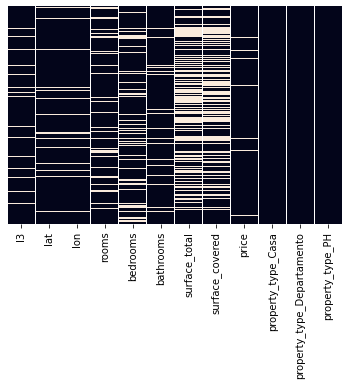

In [13]:
import seaborn as sns
sns.heatmap(df.isnull(),yticklabels=False, cbar=False)

In [11]:
# elimination of null values, in no case exceeds 10% of the data

df.dropna(inplace=True)

In [12]:
# deleting duplicates

df.drop_duplicates(inplace=True)

In [13]:
# new df shape

df.shape

(186583, 12)

<AxesSubplot:xlabel='l3'>

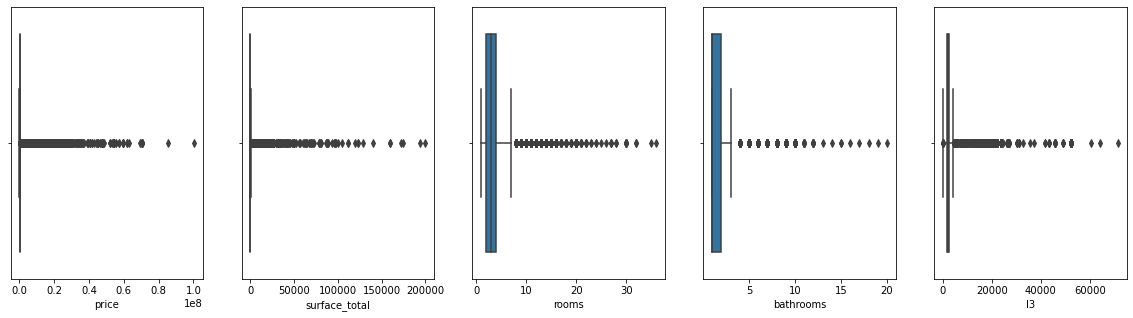

In [17]:
# outlier display

import matplotlib.pyplot as plt
import seaborn as sns
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(20,5))
sns.boxplot(data=df, x="price",ax=ax1)
sns.boxplot(data=df, x="surface_total",ax=ax2)
sns.boxplot(data=df, x="rooms",ax=ax3)
sns.boxplot(data=df, x="bathrooms",ax=ax4)
sns.boxplot(data=df, x="l3",ax=ax5)


#sns.boxplot(data=df, x="",ax=ax8)

In [15]:
# I define a function that finds lower and upper limit of distributions

def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary

Rooms

In [16]:
# I find limits and remove outliers

rooms_upper_limit, rooms_lower_limit = find_skewed_boundaries(df, "rooms", 1.5)
print("limits: ", rooms_lower_limit, rooms_upper_limit)
df.drop(df[ (df.rooms > rooms_upper_limit) | (df.rooms < rooms_lower_limit) ].index , inplace=True)

limits:  -1.0 7.0


In [17]:
print("quantiles 1-3: ", df.rooms.quantile(0.01), df.rooms.quantile(0.99))

quantiles 1-3:  1.0 7.0


Bedrooms

In [18]:
# I find limits and remove outliers

bedrooms_upper_limit, bedrooms_lower_limit = find_skewed_boundaries(df, "bedrooms", 1.5)
print("limits: ", bedrooms_lower_limit, bedrooms_upper_limit)
df.drop(df[ (df.bedrooms > rooms_upper_limit) | (df.bedrooms < rooms_lower_limit) ].index , inplace=True)

limits:  -2.0 6.0


In [19]:
print("quantiles: ", df.bedrooms.quantile(0.01), df.rooms.quantile(0.99))

quantiles:  1.0 7.0


Bathrooms

In [20]:
# I find limits and remove outliers

bathrooms_upper_limit, bathrooms_lower_limit = find_skewed_boundaries(df, "bathrooms", 1.5)
print("limits: ", bathrooms_lower_limit, bedrooms_upper_limit)
df.drop(df[ (df.bathrooms > rooms_upper_limit) | (df.bathrooms < rooms_lower_limit)].index , inplace=True)

limits:  -0.5 6.0


In [21]:
# I print the values of the first and third quartile to see if they make sense

print("quantiles: ", df.bathrooms.quantile(0.01), df.rooms.quantile(0.99))

quantiles:  1.0 7.0


Surface_total

In [22]:
# I print the values of the first and third quartile to see if they make sense

surface_total_upper_limit, surface_total_lower_limit = find_skewed_boundaries(df, "surface_total", 1.5)
print("limits: ", surface_total_lower_limit,surface_total_upper_limit)
df.drop(df[(df.surface_total > surface_total_upper_limit) | (df.surface_total < surface_total_lower_limit)].index , inplace=True)


limits:  -90.0 286.0


In [23]:
# I print the values of the first and third quartile to see if they make sense

print("quantiles: ", df.surface_total.quantile(0.01), df.surface_total.quantile(0.99))

quantiles:  27.0 270.0


Price

In [24]:
# I find limits and remove outliers

price_upper_limit, price_lower_limit = find_skewed_boundaries(df, "price", 1.5)
df.drop(df[ (df.price > price_upper_limit) | (df.price < price_lower_limit) ].index , inplace=True)
print(price_lower_limit, price_upper_limit)

-147500.0 392500.0


In [25]:
# I print the values of the first and third quartile to see if they make sense

print("quantiles: ", df.price.quantile(0.01), df.price.quantile(0.99))

quantiles:  1000.0 370000.0


l3

In [26]:
# I find limits and remove outliers

l3_upper_limit, l3_lower_limit = find_skewed_boundaries(df, "price", 1.5)
df.drop(df[ (df.l3 > l3_upper_limit) | (df.l3 < l3_lower_limit) ].index , inplace=True)
print(price_lower_limit, price_upper_limit)

-147500.0 392500.0


In [27]:
# I print the values of the first and third quartile to see if they make sense

print("quantiles: ", df.l3.quantile(0.01), df.l3.quantile(0.99))

quantiles:  726.656537366849 18544.15204136751


<AxesSubplot:xlabel='l3'>

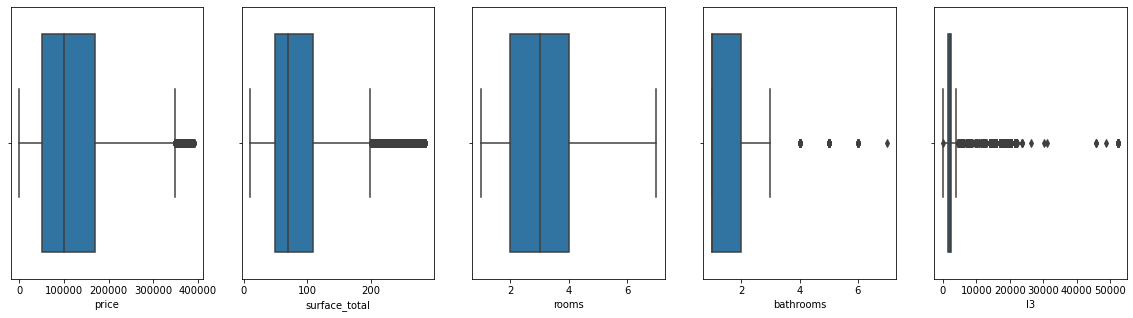

In [28]:
# plotting the distibution of the variables after elimination of outliers, nulls and duplicates.

import matplotlib.pyplot as plt
import seaborn as sns
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(20,5))
sns.boxplot(data=df, x="price",ax=ax1)
sns.boxplot(data=df, x="surface_total",ax=ax2)
sns.boxplot(data=df, x="rooms",ax=ax3)
sns.boxplot(data=df, x="bathrooms",ax=ax4)
sns.boxplot(data=df, x="l3",ax=ax5)

In [29]:
# df shape
df.shape

(155470, 12)

In [30]:
# I define independent and dependent variables for models

X = df.drop(["price","l3"],axis=1)
y = df['price']

In [31]:
X.head(2)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type_Casa,property_type_Departamento,property_type_PH
43,-34.619633,-58.704918,1.0,1.0,1.0,25.0,25.0,1,0,0
58,-34.611091,-58.404405,2.0,1.0,1.0,32.0,32.0,0,1,0


In [32]:
# I scale the Xs

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scl = StandardScaler()
X = scl.fit_transform(X)

### 2. Modeling

In [38]:
# train-test split application on data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)

#### 2.1 Decision Tree

In [37]:
# I import and create the object

from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=None)


In [38]:
# I train the model

tree = tree.fit(X_train,y_train)

In [39]:
# I predict about the train and test set

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

In [40]:
# evaluation on train and test

from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Mean Absolut Error
MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test= mean_absolute_error(y_test, y_test_pred)

# Mean Squared Error
RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# R2 Score
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test = metrics.r2_score(y_test, y_test_pred)

# I print the evaluation metrics of the model
print("MAE_train_arbol: ", MAE_train)
print("MAE_test_arbol: ", MAE_test)
print("RMSE_train_arbol: ",RMSE_train)
print("RMSE_test_arbol: ",RMSE_test)
print("R2_train_arbol", r2_train)
print("R2_test_arbol",r2_test)

MAE_train_arbol:  4718.527342465174
MAE_test_arbol:  51343.041965555545
RMSE_train_arbol:  19240.97624018907
RMSE_test_arbol:  81950.59909004101
R2_train_arbol 0.9533203181554453
R2_test_arbol 0.1598048920952435


In [41]:
# I apply Cross Validation as a sampling technique to evaluate model performance
from sklearn.model_selection import cross_val_score

dt_scores = cross_val_score(tree, X_train, y_train, cv = 5)
print("mean cross validation score: {}".format(np.mean(dt_scores)))
print("score without cv: {}".format(tree.score(X_train, y_train)))

from sklearn.metrics import r2_score

print("test r2_score",r2_score(y_test, tree.predict(X_test)))
print("test score ", tree.score(X_test, y_test))

mean cross validation score: 0.13268500721972903
score without cv: 0.9533203181554453
test r2_score 0.1598048920952435
test score  0.1598048920952435


In [42]:
# I apply Grid Search as a hyperparameter optimization technique

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

def dtree_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 30)}
    # decision tree model
    dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

dtree_grid_search(X,y,5)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'criterion': 'entropy', 'max_depth': 24}

In [43]:
# I created a new Decision Tree with optimal and evaluated max_depth

tree = DecisionTreeRegressor(max_depth=22)
tree = tree.fit(X_train,y_train)
y_arbol_train_pred = tree.predict(X_train)
y_arbol_test_pred = tree.predict(X_test)

MAE_train_arbol = mean_absolute_error(y_train, y_arbol_train_pred)
MAE_test_arbol = mean_absolute_error(y_test, y_arbol_test_pred)
RMSE_train_arbol = np.sqrt(mean_squared_error(y_train, y_arbol_train_pred))
RMSE_test_arbol = np.sqrt(mean_squared_error(y_test, y_arbol_test_pred))
r2_train_arbol = metrics.r2_score(y_train, y_arbol_train_pred)
r2_test_arbol = metrics.r2_score(y_test, y_arbol_test_pred)

print("MAE_train_arbol: ", MAE_train_arbol)
print("MAE_test_arbol: ", MAE_test_arbol)
print("RMSE_train_arbol: ",RMSE_train_arbol)
print("RMSE_test_arbol: ",RMSE_test_arbol)
print("R2_train_arbol", r2_train_arbol)
print("R2_test_arbol",r2_test_arbol)


MAE_train_arbol:  17713.503393114144
MAE_test_arbol:  50336.14756751369
RMSE_train_arbol:  35500.625538590495
RMSE_test_arbol:  77962.92439175092
R2_train_arbol 0.8410920255183991
R2_test_arbol 0.23958246107848025


***

#### 2.2 Random Forest

In [44]:
# I import the library

from sklearn.ensemble import RandomForestRegressor

In [45]:
# I train the model, I give it the estimators, the number of cores to work with, I leave a piece out of the bag

clf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score =True, random_state =42)
clf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42)

In [46]:
# I evaluate the scores of the models with cross validation: five samples

clf_scores = cross_val_score(clf,X_train, y_train, cv=5)
clf_scores

array([0.51091046, 0.49803437, 0.49036064, 0.48600265, 0.50298371])

In [47]:
# I make the predictions about the train and the test set and then apply evaluation metrics

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [48]:
# evaluation metrics

from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np

MAE_reg = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)
RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test = metrics.r2_score(y_test, y_test_pred)

print("MAE_reg: ", MAE_reg)
print("MAE_test: ", MAE_test)
print("RMSE_train: ",RMSE_train)
print("RMSE_test: ",RMSE_test)
print("R2_train_arbol", r2_train)
print("R2_test_arbol",r2_test)

MAE_reg:  17501.8662534446
MAE_test:  41917.12446725635
RMSE_train:  28183.266649939596
RMSE_test:  62584.58232275242
R2_train_arbol 0.899848757864289
R2_test_arbol 0.5099836181051647


In [49]:
# I evaluate the model, out of the bag

clf.oob_score_

0.5003141976151461

In [50]:
# I import randomizeSearchCV to implement an Adaboost and see its effects...

from sklearn.model_selection import RandomizedSearchCV

In [51]:
# I apply an adaboost to find the best parameters

param_dist = {"n_estimators":[10,50,100,500,1000], "max_features":[2,3,4,5]}

ada_clf = RandomizedSearchCV(RandomForestRegressor(), 
                          param_distributions = param_dist,
                          cv=3,
                          n_iter=10,
                          n_jobs=-1)

ada_clf.fit(X_train, y_train)
ada_clf.best_params_

{'n_estimators': 1000, 'max_features': 4}

In [52]:
# I apply the random forest again, this time with the optimal parameters found with adaboost

clf = RandomForestRegressor(n_estimators=500, max_features=5, n_jobs=-1, oob_score=True, random_state=42)

In [53]:
# I train the model

clf.fit(X_train,y_train)

RandomForestRegressor(max_features=5, n_estimators=500, n_jobs=-1,
                      oob_score=True, random_state=42)

In [54]:
# I make the predictions with the optimized regress

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [55]:
# evaluation metrics

MAE_reg = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)
RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test = metrics.r2_score(y_test, y_test_pred)

# I print the evaluation metrics of the model

print("MAE_reg: ", MAE_reg)
print("MAE_test: ", MAE_test)
print("RMSE_train: ",RMSE_train)
print("RMSE_test: ",RMSE_test)
print("R2_train_arbol", r2_train)
print("R2_test_arbol",r2_test)

MAE_reg:  17395.70165611511
MAE_test:  41945.930702146805
RMSE_train:  27843.744876600227
RMSE_test:  62237.08586783666
R2_train_arbol 0.9022472525977506
R2_test_arbol 0.5154100735785282


In [56]:
# I see the score: out of the bag, to validate the generalization of the optimized random forest

clf.oob_score_

0.5126722199567912

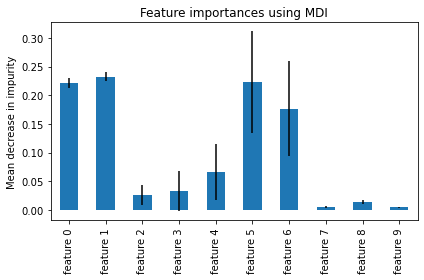

In [57]:
# I see the weight of each variable in the model

std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)
feature_names = [f'feature {i}' for i in range(X.shape[1])]
importances = clf.feature_importances_

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

***

#### 2.3 Multiple Linear Regression

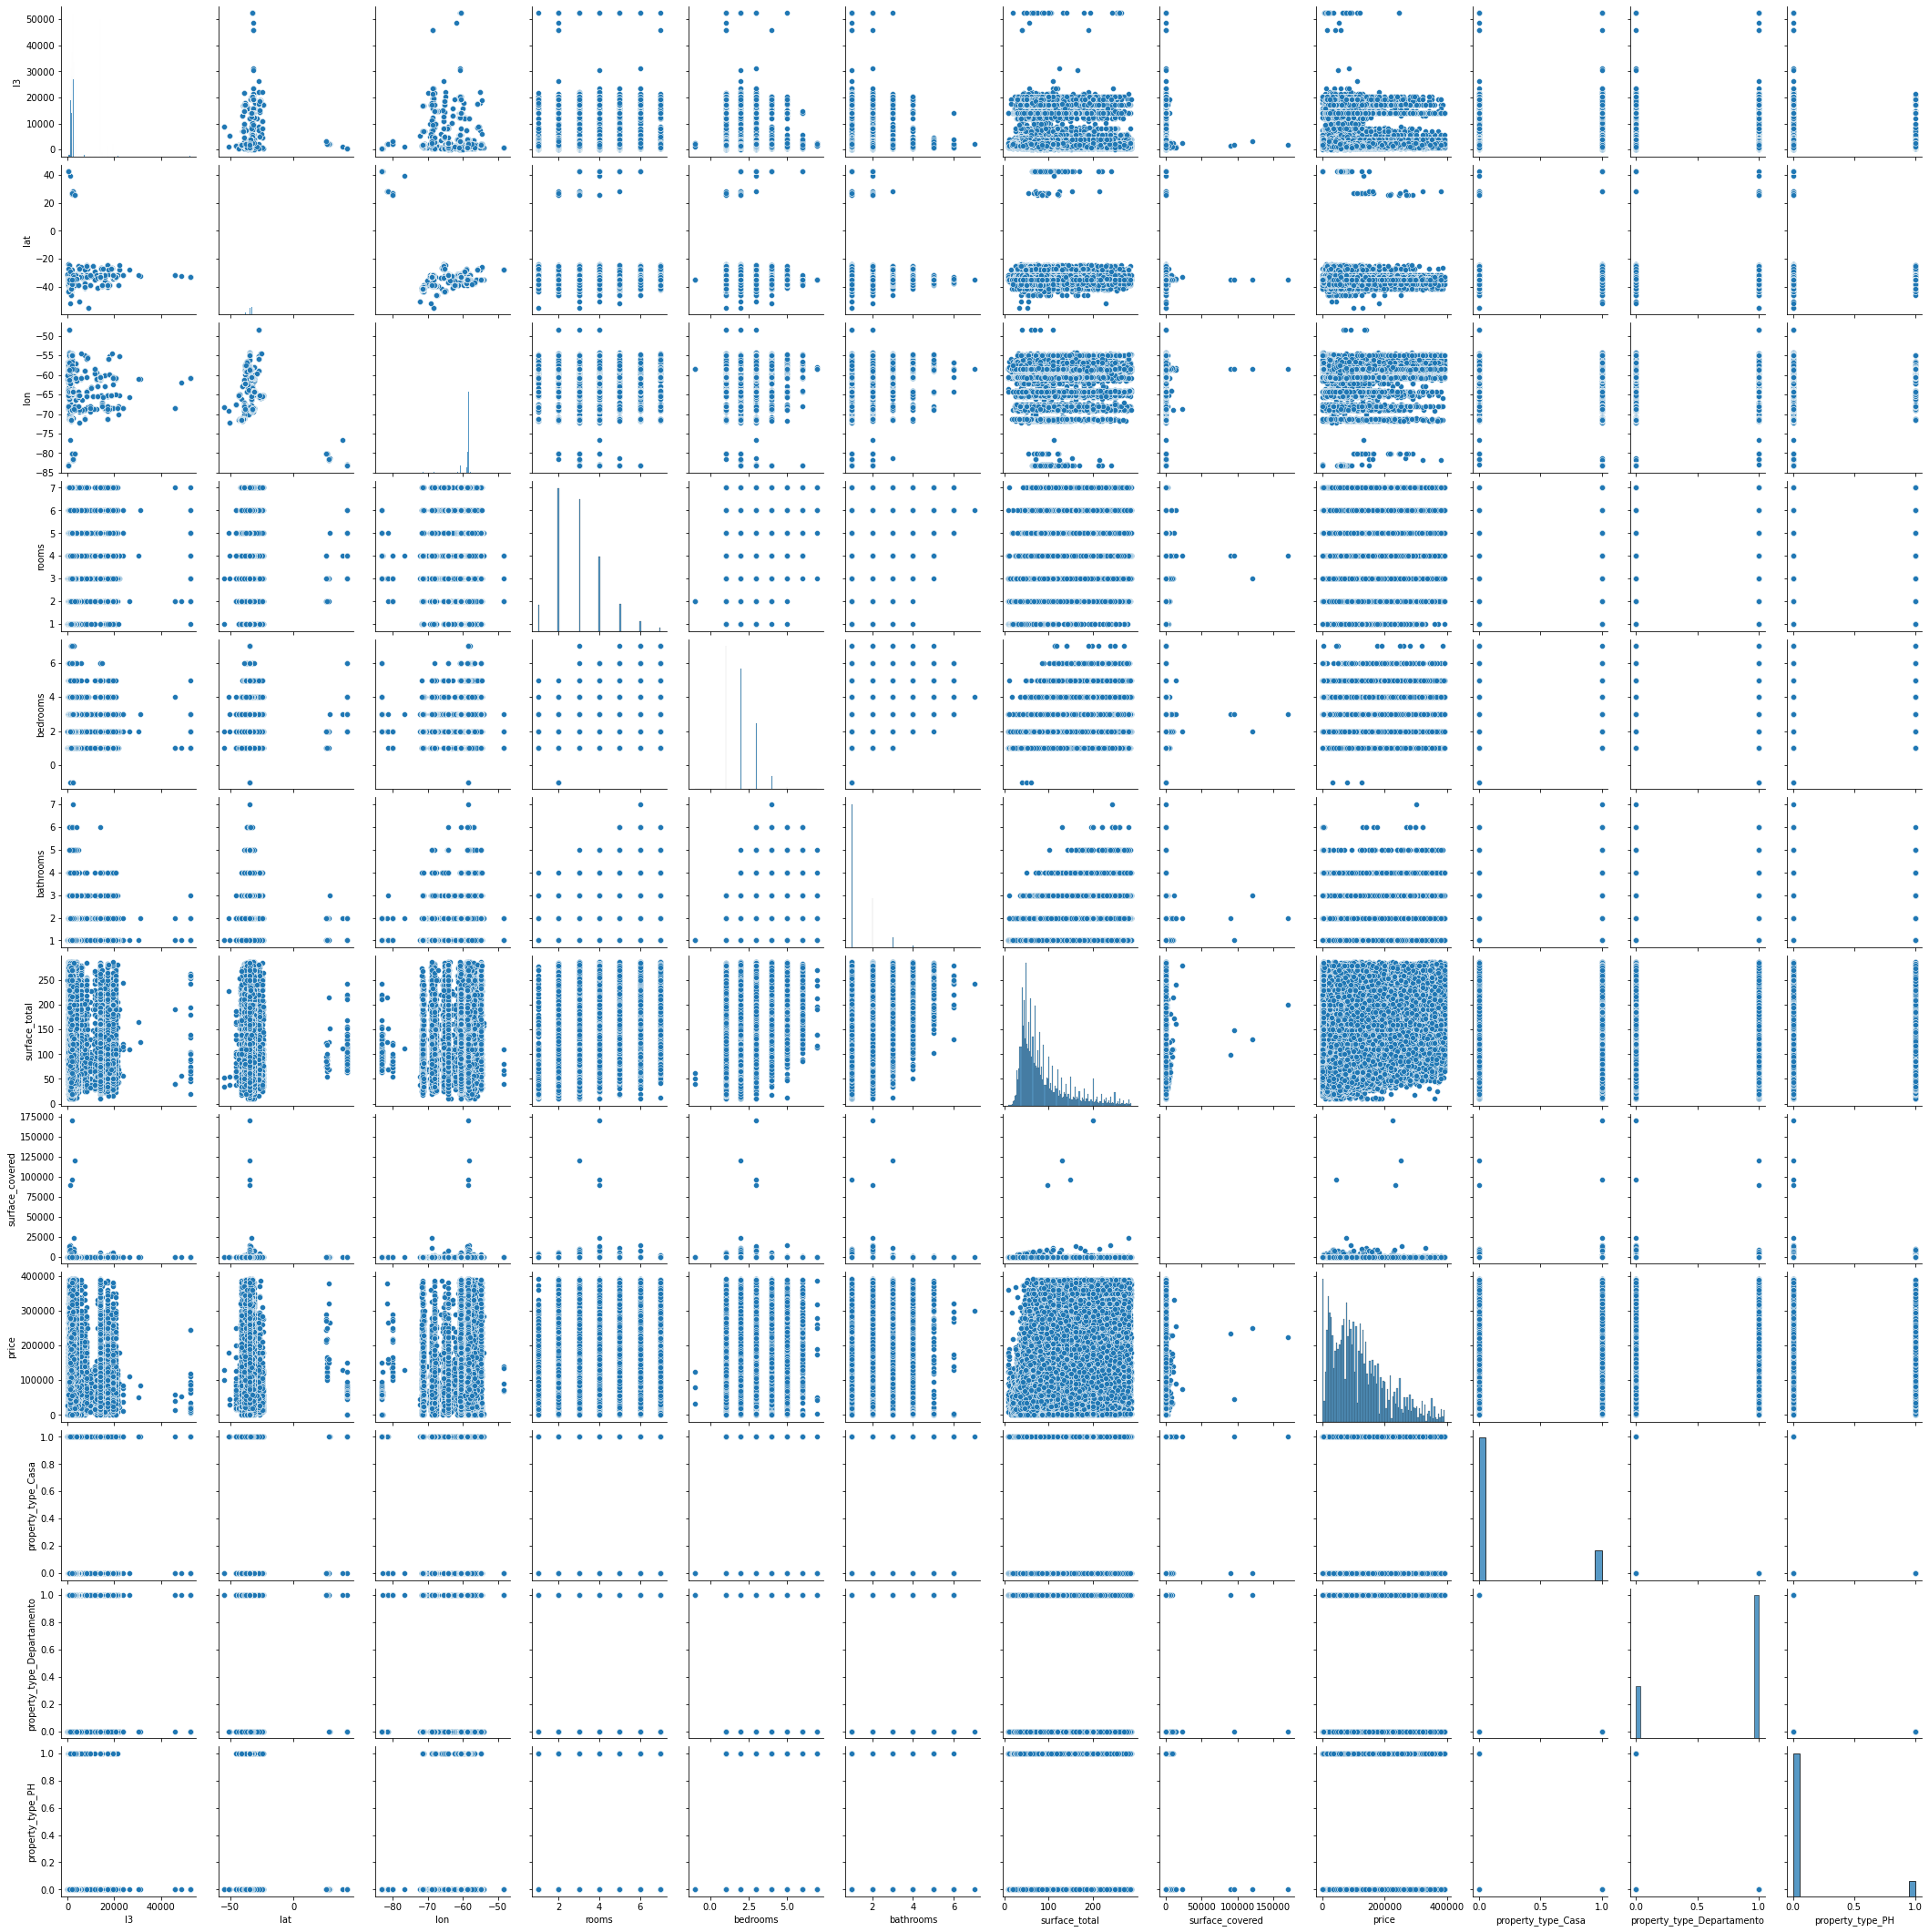

In [58]:
# I visualize correlations graphically

sns.pairplot(df)

<AxesSubplot:>

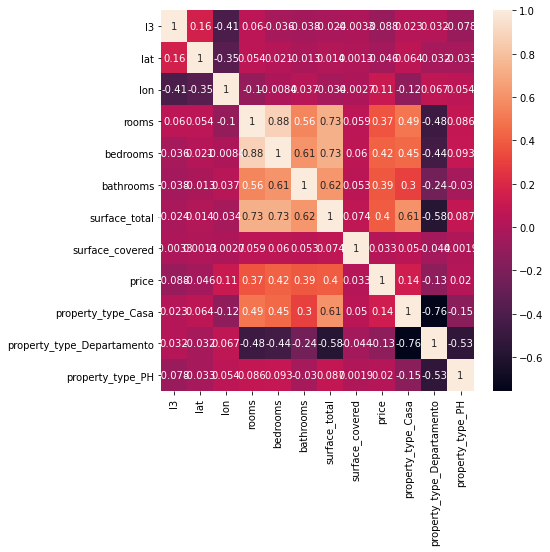

In [59]:
# visualize correlation with magnitude and direction

fig =plt.subplots(figsize=(7,7))
sns.heatmap(df.corr(), annot=True)

In [43]:
# I import relevant libraries

import numpy as np
sns.set()

In [44]:
# I import the library with linear regression and create the object

from sklearn.linear_model import LinearRegression
reg_1 = LinearRegression()

In [45]:
# I train the model

reg_1.fit(X_train, y_train)

LinearRegression()

In [46]:
# I predict in train and test

y_train_pred = reg_1.predict(X_train)
y_test_pred = reg_1.predict(X_test)

In [51]:
# evaluation metrics

MAE_reg = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)
RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test = metrics.r2_score(y_test, y_test_pred)

print("MAE_reg: ", MAE_reg)
print("MAE_test: ", MAE_test)
print("RMSE_train: ",RMSE_train)
print("RMSE_test: ",RMSE_test)
print("R2_train_arbol", r2_train)
print("R2_test_arbol",r2_test)


MAE_reg:  59068.89721349293
MAE_test:  59689.33534271106
RMSE_train:  77776.0282220108
RMSE_test:  78620.06420985973
R2_train_arbol 0.23727987916150817
R2_test_arbol 0.22670950628632536


In [52]:
print(X_train.shape, X_test.shape)

(139923, 10) (15547, 10)


In [1]:
# applied Polyomial Features to extend the number of variables

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(7, include_bias=False)
X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)
print(X_train_new.shape, X_test_new.shape)

NameError: name 'X_train' is not defined

In [ ]:
# I train linear regression with the new features

reg_2 = LinearRegression()
reg_2.fit(X_train_new, y_train)
y_train_pred = reg_2.predict(X_train_new)
y_test_pred = reg_2.predict(X_test_new)

In [ ]:
# linear regression evaluation metrics with new features

MAE_reg = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)
RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test = metrics.r2_score(y_test, y_test_pred)

print("MAE_reg: ", MAE_reg)
print("MAE_test: ", MAE_test)
print("RMSE_train: ",RMSE_train)
print("RMSE_test: ",RMSE_test)
print("R2_train_arbol", r2_train)
print("R2_test_arbol",r2_test)

***

#### 2.4 Regression with Regularization (Ridge and Lasso)

In [ ]:
# I import Ridge and Lasso

from sklearn.linear_model import Ridge, Lasso

Ridge Regression

In [ ]:
# I define a function that evaluates regression

def evaluar_regresion(model,x,y, X_train, X_test, y_train, y_test):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

    plt.figure(figsize = (12,4))
    plt.subplot(1,3,1)
    plt.scatter(x,y, s = 2, label = 'Datos')
    plt.plot(x, y_real, '--',label ='Curva Teórica', c = 'r')
    
    list1, list2 = zip(*sorted(zip(X_train[:,0], y_train_pred)))
    plt.plot(list1, list2,label ='Regresión (train)')
    
    list1, list2 = zip(*sorted(zip(X_test[:,0], y_test_pred)))
    plt.plot(list1, list2,label = 'Regresión (test)')

    
#     plt.scatter(X_train[:,0],y_train_pred,label ='Regresión (train)', s = 8)
#     plt.scatter(X_test[:,0],y_test_pred,label = 'Regresión (test)', s = 8)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()


    plt.subplot(1,3,2)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,3,3)
    ax.scatter(y_test,y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

In [ ]:
# Ridge regularization (create object and train model with X_train_new (polynomial features))

reg_ridge = Ridge(alpha= 0.0001)
reg_ridge.fit(X_train_new,y_train)
#print(f'Pendientes: {reg_ridge.coef_}')
#print(f'Ordenada: {reg_ridge.intercept_}')
evaluar_regresion(reg_ridge, X,y, X_train_new, X_test_new, y_train, y_test)

In [ ]:
# búsco los mejores hiperparámetros por medio de grid search (podría utilizar también randomsearch)

from sklearn.model_selection import GridSearchCV
params_Ridge = {'alpha': [1,0.1,0.01,0.001,0.0001,0] , "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
Ridge_GS = GridSearchCV(reg_ridge, param_grid=params_Ridge, n_jobs=-1)
Ridge_GS.fit(X_train_new,y_train)
Ridge_GS.best_params_

In [ ]:
# create the new regression with optimized hyperparameters

reg_ridge = Ridge(alpha= 0.0001)
reg_ridge = reg_ridge.fit(X_train_new,y_train)
#print(f'Pendientes: {reg_ridge.coef_}')
#print(f'Ordenada: {reg_ridge.intercept_}')

In [ ]:
# I evaluate the optimized regression

evaluar_regresion(reg_ridge, X, y, X_train_new, X_test_new, y_train, y_test)

In [ ]:
# I print the scores in a df

scores = pd.DataFrame(Ridge_GS.cv_results_)
scores

In [ ]:
# I observe the importance of each feature in the model

reg_ridge.feature_importances_

Regresión Lasso

In [ ]:
# Lasso regularization (create object and train model with X_train_new (polynomial features))

reg_lasso = Lasso(alpha = 0.001)
reg_lasso.fit(X_train_new,y_train)
#print(reg_lasso.coef_, reg_lasso.intercept_)
# y_train_pred_lasso = reg_lasso.predict(X_train_new)
# y_test_pred_lasso = reg_lasso.predict(X_test_new)

In [ ]:
# I evaluate the regression

evaluar_regresion(reg_lasso, X,y, X_train_new, X_test_new, y_train, y_test)

In [ ]:
# I search for best hyperparameters by grid search

params_Lasso = {'alpha': [1,0.1,0.01,0.001,0.0001,0] , "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
Lasso_GS = GridSearchCV(reg_ridge, param_grid=params_Lasso, n_jobs=-1)
Lasso_GS.fit(X_train_new,y_train)
Lasso_GS.best_params_

In [ ]:
# I create new regression with optimized hyperparameters

reg_lasso = Lasso(alpha = 0.001)
reg_lasso.fit(X_train_new,y_train)
#print(reg_lasso.coef_, reg_lasso.intercept_)
# y_train_pred_lasso = reg_lasso.predict(X_train_new)
# y_test_pred_lasso = reg_lasso.predict(X_test_new)


In [ ]:
# I evaluate the optimized regression 

evaluar_regresion(reg_lasso, X,y, X_train_new, X_test_new, y_train, y_test)

In [ ]:
# I print the scores in a df

scores = pd.DataFrame(Lasso_GS.cv_results_)
scores

***

#### 2.5 Boosting Ensamble

XgBoost

In [ ]:
pip install xgboost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

***

#### 2.6 Dimensionality Reduction

Singular Value Decomposition

In [ ]:
svd=TruncatedSVD

for i in range(2,64):
    svd=TruncatedSVD(n_components=i,random_state=42)
    X_train_new=svd.fit_transform(X_train)
    X_test_new=svd.transform(X_test)
    
    tree = DecisionTreeRegressor(max_depth=10,random_state=42)
    tree.fit(X_train_new,y_train)
    
    y_pred = tree.predict(X_test_new)

svd = TruncatedSVD(63).fit(X_test)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Plot CEV para SVD")
plt.xlabel('Numero de componentes')
plt.ylabel('cumulative explained variance');


Principal Component Analysis

In [ ]:
pca_p=PCA
PCA_range = range(2, 64)

for i in PCA_range:
    pca_p=PCA(n_components=i,random_state=42)
    X_train_new=pca_p.fit_transform(X_train)
    X_test_new=pca_p.transform(X_test)
    
    tree = DecisionTreeRegressor(max_depth=10,random_state=42)
    tree.fit(X_train_new,y_train)
    
    y_pred = tree.predict(X_test_new)


***

***

#### 2.7 Clusterting

KMeans

In [ ]:
# importo la librería k-means

from sklearn.cluster import KMeans
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs, make_moons

Elbow Method

In [ ]:
# Preparamos una lista donde vamos a ir agregando las distancias medias
Sum_of_squared_distances = []

# Fiteammos un modelo para cada numero de cluster que queremos testear
K = np.arange(2,14)
for k in K:
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    # Calculamos la distancia media y agregamos a la lista
    distancia_total = km.inertia_
    distancia_media = np.divide(distancia_total,X.shape[0])
    Sum_of_squared_distances.append(distancia_media)
    
plt.figure(figsize = (10,7))
plt.plot(K, Sum_of_squared_distances, lw=3)
plt.scatter(K, Sum_of_squared_distances,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Inercia media')
plt.title('Método del codo para el Dataset 3')

plt.show()

In [ ]:
# I define and train the model with the number of optimal clusters found with elbow method

km = KMeans(n_clusters=4)
km = km.fit(X)

# I get the position of the centers and the labels
etiquetas_ = km.labels_
centros_ = km.cluster_centers_

# Plotting the cluster centers and the data points on a 2D plane
sns.scatterplot(X[:, 0], X[:, -1], hue = etiquetas_)
sns.scatterplot(centros_[:, 0], centros_[:, 1],color='black', marker="+", s=1000)
plt.title('Data points and cluster centroids')
plt.show()

Silouhette

In [ ]:
# We prepare a list where we are going to add the average values of silhouette
lista_sil = []

# Let's set a model for each cluster number we want to test
for k in range(2,14):
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    
# We take the labels    
    etiquetas = km.labels_
    
# We calculate the silhouette
    valor_medio_sil = silhouette_score(X, etiquetas)
    lista_sil.append(valor_medio_sil)
    
plt.figure(figsize = (10,7))
plt.plot(K, lista_sil, lw=3)
plt.scatter(K, lista_sil,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Silhouette media')
plt.title('Silhouette media para el Dataset 2')

plt.show()

In [ ]:
# List of ks for which they want to make a chart
lista_k = [4, 6, 8, 10]

for i, k in enumerate(lista_k):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(X[:, 0], X[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-12, 12])
    ax2.set_xlim([-12, 12])
    ax2.set_xlabel('Eruption time in mins')
    ax2.set_ylabel('Waiting time to next eruption')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

In [ ]:
# I create the kmeans object with the optimal number of clusters I found with elbow and silohuette method

kmeans = KMeans(n_clusters=4, random_state=0)

In [ ]:
# I train the model

kmeans.fit(X,y)

In [ ]:
# I can order the model labels

etiquetas = kmeans.labels_

In [ ]:
# I can order the centers of the clusters

centros_1 = kmeans.cluster_centers_
print(centros_1)

In [ ]:
# plotting clusters

sns.scatterplot(X[:, 0], X[:, -1], hue = etiquetas) 

# "hue": Grouping variable that will produce points with different colors. Can be either categorical or numeric, although color mapping will behave differently in latter case.
sns.scatterplot(centros_1[:, 0], centros_1[:, 1],color='black', marker="+", s=1000)
plt.title('Data points and cluster centroids')
plt.show()

In [ ]:
print(df.shape)
print(X.columns)

In [ ]:
# let´s see the confusion matrix.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y1, etiquetas)
df_cm = pd.DataFrame(cm, index = [i for i in ['Original_0','Original_1','Original_2','Original_3']],
                  columns = [i for i in ['Pred_0','Pred_1','Pred_2','Pred_3']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt="d")

***